In [5]:
import numpy as np

from triqs.gf import *
from triqs.gf.meshes import MeshDLRImFreq, MeshDLRImTime

from triqs.gf import *
from triqs.operators import *
from triqs.operators.util.hamiltonians import h_int_slater
from triqs.operators.util import *
from triqs.operators.util.hamiltonians import *

from triqs.atom_diag import *

import numpy as np
from itertools import product
import matplotlib.pylab as plt
import time
from triqs.plot.mpl_interface import oplot,plt

from gwsolver import GWSolver
from gwsolver_symmetric import GWSolverSymmetric

def number_of_particles(g_w):
    return g_w.total_density().real

def number_of_particles_DLR(g_w):
    g_dlr = make_gf_dlr(g_w)
    rho = g_dlr.density()
    N = 0
    for name, g in g_w:
        N += np.sum(np.diag(rho[name].data)).real
    return N

def dyson(g0_w, mu):
    g_w = g0_w.copy()
    for name, g in g0_w:
        g_w[name] = (g0_w[name].inverse() - mu).inverse()
    return g_w

def fix_particle_number(g, N, eps = 1e-3):
    g_w = g.copy()
    step = 1.0

    particle_number = number_of_particles(g_w)

    while abs(particle_number - N) > eps:
        # print(particle_number)
        if particle_number - N > 0:
            g_w = dyson(g_w, step)
        elif particle_number - N < 0:
            g_w = dyson(g_w, -step)
        step = 0.99 * step
        particle_number = number_of_particles(g_w)

    return g_w

def number_of_particles_from_ad(H, fundamental_operators, number_operator, beta, mu):
    Hmu = H + mu * number_operator
    atomic_diagonal = AtomDiagComplex(Hmu, fundamental_operators)
    density_matrix = atomic_density_matrix(atomic_diagonal, beta)
    filling = trace_rho_op(density_matrix, number_operator, atomic_diagonal)
    return filling.real, atomic_diagonal

def fix_atomic_diag(H, fundamental_operators, target_occupation, number_operator, beta, mu = None, eps = 1e-6):
    if mu is None:
        mu = 0

    step = 1.0

    occupation, atomic_diagonal = number_of_particles_from_ad(H, fundamental_operators, number_operator, beta, mu)

    previous_direction = None
    iterator = 0
    while abs(occupation - target_occupation) > eps:
        if occupation - target_occupation > 0:
            if previous_direction == 'decrement':
                step /= 2
            previous_direction = 'increment'
            mu += step
        if occupation - target_occupation < 0:
            if previous_direction == 'increment':
                step /= 2
            previous_direction = 'decrement'
            mu -= step
        occupation, atomic_diagonal = number_of_particles_from_ad(H, fundamental_operators, number_operator, beta, mu)
        iterator += 1
        # print(f"ED Iteration {iterator}: mu = {mu}, N = {occupation}", end='\r')
    return atomic_diagonal, mu

def exact_diag(tij, V, occupation = None, beta = 100, nw = 1 * 1024):
    spin_names = ['up', 'dn']
    orbital_names = range(len(tij))

    if occupation is None:
        occupation = len(tij)

    fundamental_operators = [(spin_name, orbital_name) for spin_name, orbital_name in product(spin_names, orbital_names)]

    N = 0
    for i in orbital_names:
        N += n('up', i) + n('dn', i)

    H = h_int_slater(spin_names, len(orbital_names), V, off_diag = True, complex = True)
        
    for spin, i, j in product(spin_names, orbital_names, orbital_names):
        H += tij[i, j] * c_dag(spin, i) * c(spin, j)
        
    atomic_diagonal, mu = fix_atomic_diag(H, fundamental_operators, occupation, N, beta)

    gf_struct = [('dn', len(orbital_names)),
                ('up', len(orbital_names))]

    G_w = atomic_g_iw(atomic_diagonal, beta, gf_struct, nw)
    return G_w

def generate_g0_w(tij, mesh, spin_names = ['up', 'dn']):
    g_inv = Gf(mesh = mesh, target_shape = np.shape(tij))
    g_inv << iOmega_n - tij.transpose()
    g = g_inv.inverse()
    return BlockGf(block_list = [g] * 2, name_list = spin_names, make_copies = False)

def coulomb_matrix(orbitals, U, non_local = True):
    Vij = np.zeros([orbitals] * 2)
    for i in range(orbitals):
        for j in range(orbitals):
            Vij[i, j] = round(U / (abs(i - j) + 1), 2)
    

    if non_local:
        return Vij

    return np.diag(Vij.diagonal())

def coulomb_tensor(orbitals, U, non_local = True):
    Vij = coulomb_matrix(orbitals, U, non_local)
    Vijkl = np.zeros([orbitals] * 4)
    for i in range(orbitals):
        for j in range(orbitals):
            Vijkl[i, j, i, j] = Vij[i, j]
    return Vijkl


orbitals = 50

t = 1.0

tij = np.zeros([orbitals] * 2)
for i in range(orbitals - 1):
    tij[i, i + 1] = -t
    tij[i + 1, i] = -t

U = 0.1
Vij = coulomb_matrix(orbitals, U)
Vijkl = coulomb_tensor(orbitals, U)

beta = 100


mesh = MeshDLRImFreq(beta = 100, statistic = 'Fermion',  w_max = 2.0, eps = 1e-12, symmetrize = False)
mesh_symmetric = MeshDLRImFreq(beta = 100, statistic = 'Fermion',  w_max = 2.0, eps = 1e-12, symmetrize = True)

start = time.perf_counter()
gw = GWSolver(generate_g0_w(tij, mesh), Vij, self_interactions = False, hartree_flag = True, fock_flag = True)
print(time.perf_counter() - start)
start = time.perf_counter()
gw_symmetric = GWSolverSymmetric(generate_g0_w(tij, mesh_symmetric), Vij, self_interactions = False, hartree_flag = True, fock_flag = True)
print(time.perf_counter() - start)

32.141702123997675
0.2962711560030584


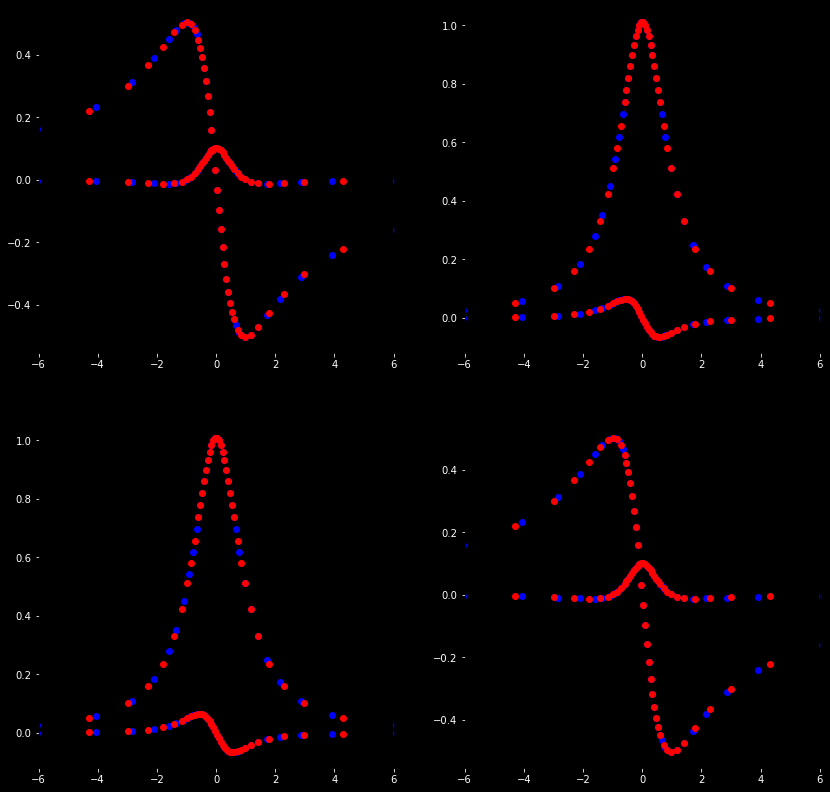

In [2]:
fig, axs = plt.subplots(orbitals, orbitals, figsize = (7 * orbitals, 7 * orbitals), facecolor = 'black')
spin = 'dn'

a = gw.g_w
b = gw_symmetric.g_w

for i in range(orbitals):
    for j in range(orbitals):
        axs[i, j].set_facecolor('black')
        axs[i, j].xaxis.label.set_color('white')
        axs[i, j].tick_params(axis = 'x', colors = 'white')
        axs[i, j].yaxis.label.set_color('white')
        axs[i, j].tick_params(axis = 'y', colors = 'white')
        axs[i, j].set_xlim(-6, 6)
        # axs[i, j].set_xlim(0, beta)

        axs[i, j].scatter([w.imag for w in a.mesh.values()], a[spin].data[:, i, j].real, color = 'blue', zorder = 1)
        axs[i, j].scatter([w.imag for w in a.mesh.values()], a[spin].data[:, i, j].imag, color = 'blue', zorder = 1)

        axs[i, j].scatter([w.imag for w in b.mesh.values()], b[spin].data[:, i, j].real, color = 'red', zorder = 1)
        axs[i, j].scatter([w.imag for w in b.mesh.values()], b[spin].data[:, i, j].imag, color = 'red', zorder = 1)